### Summary
- Cropsy is analysing recent scan data from a specific block within a vineyard. This block has
been scanned twice
- We have the block and row geometries as well as the processed vine stats and locations for the first scan.
- The second scan was done on a different day and has
similar vine information as the first scan.
- The goal is to create a pipeline to clean the data from the second scan, match it with the first, and create a summary analysis for internal use and customer delivery.

### Data
- **block.geojson:** A single Polygon defining the boundaries of the block within a
vineyard. The block also contains important row spacing and vine spacing
information.
- **row.geojson:** A collection of LineString and MultiLineStrings with row ids and
numbers.
- **scan1_processed_insights.csv:** A .csv containing data of vines and posts
detected by a Cropsy tractor. As well as corresponding attributes including x, y
coordinates, time in epoch, and data. This data has been tidied, each vine is a
vine spacing away from each other, and posts are in line.
- **scan2_raw_insights.csv:** A .csv containing similar data to scan1. Except it
has not been tidied, that is, the geolocations need to be tidied and missing
vines need to be added.
- The attributes important for statistics are Cane Count, Bud Count, and
whether the vines are missing or not.

### Task
- Tidy the second scan and assign missing vines in the gaps.
- Match the second scan data with the previous scan by location and construct finalised data for that block by aggregating the two scans.
- For Cropsy internal metrics, report statistics on scan quality and reproducibility.
- For customer delivery, report on vine attribute statistics and overall data quality.

### My Code
- *zhaohan.xiong.ipynb*: This notebook to do all the analysis
- *requirements.txt*: Dependencies for this project
- *pyvenv.cfg*: Python version
- *.gitignore*: Files to not track with git
- Comments are placed in the code below for the working and the notebook is sectioned by task

Install dependencies to run this notebook:
```
pip install -r requirements.txt
```

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

##### Load Data

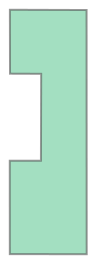

In [491]:
# json geometry data
rows = gpd.read_file(open("data/rows.geojson"))
block = gpd.read_file(open("data/block.geojson"))

# csv individual vine data
scan1 = pd.read_csv("data/scan1_processed_insights.csv")
scan2 = pd.read_csv("data/scan2_raw_insights.csv")

# show block geometry
block.geometry[0]

##### Tidy Data

In [502]:
# vine spacing, 2.4 for x, 1.8 for y
vin_space = block["vineSpacingDistance"][0]

# tolerance for adjacent vine spacing, if vines are 3.6 distance apart, it means there probably should be another one in between
vin_space_tol = vin_space * 2

# unpack all coordinates in data frame (this is where we expect vines to be located in each row in increments of vin_space)
rows_expanded = rows.geometry.explode(index_parts=True).get_coordinates()

# check post locations too to make sure each row matches, since there were no post information, I had to look at each row
# and look at the location of the posts, then take the union of y coordinates in all rows, also i had to round the coordinates for a rough estimate
# some of these coords seem to be pretty closely placed but i dont have enough information so im just gonna leave them for now
post_y_coords = np.array(list(set().union(*[set(scan2[(scan2.x - x < 1e5) & (scan2.Type == "POST")].y.values.round()) for x in scan2.x.round(2).unique()])))

# iterate through each segment (would be inefficient if we had many rows but good enough for now)
# could parallelize each loop on the cloud if implemented to process lots of data, or transform dataframes into pyspark
# also initialize some lists to store stuff
missing_y_all, missing_x_all, row_id_all = [], [], []
missing_y_post_all, missing_x_post_all, row_id_post_all = [], [], []
for row, segment in rows_expanded.index.unique():

    # extract coordinates for segment of row coordinates
    x0, y0 = rows_expanded.loc[row, segment].iloc[0]
    x1, y1 = rows_expanded.loc[row, segment].iloc[1]

    # get row id for the segment
    row_id = rows.RowId[row]

    # query data from scan2 to get rows which relate to the current row segment we are looking at
    scan2_row = scan2[(scan2.RowId == row_id) & (scan2.Type == "VINE") & (scan2.y >= y0) & (scan2.y <= y1)]

    # query the posts data for this row segment
    scan2_post = scan2[(scan2.RowId == row_id) & (scan2.Type == "POST") & (scan2.y >= y0) & (scan2.y <= y1)]
    
    # check data, have tolerance as coords are not exact
    assert x1 - x0 < 1e-5, "Row x-coodinate misaligned!"
    assert scan2_row.x.diff().sum() < 1e-5, "Row has different x-coordinates!"

    # if no vine data found for that row
    if scan2_row.shape[0] == 0:

        # generate all the expected y coords for the vines the row 
        missing_y = (y0 + (np.arange(0, np.ceil((y1 - y0) / vin_space)) * vin_space)).tolist()
        
    # if data found for vines in row, then we have to check its completeneess
    else:

        # compute adjacent distances in sorted y-coordinates
        y_coords = scan2_row.y.sort_values()
        adj_dist = y_coords.diff().values
        adj_dist[0] = vin_space

        # find which y-coords are above tolerance (hence missing data before these coordinate)
        problem_index = np.where(adj_dist > vin_space_tol)[0]
        gaps = adj_dist[problem_index]

        # check start and ends of row for missing data
        missing_y_start = y_coords.values[0] - (np.arange(0, np.ceil((y_coords.values[0] - y0) / vin_space))[1:] * vin_space)
        missing_y_end = y_coords.values[-1] + (np.arange(0, np.ceil((y_coords.values[-1] - y1) / vin_space))[1:] * vin_space)

        # generate all missing y coords for row
        missing_y = [(y_coords.values[i] - (np.arange(0, np.ceil(adj_dist[i] / vin_space) - 1) * vin_space))[1:].tolist() for i in problem_index]
        missing_y = missing_y_start.tolist() + [item for sublist in missing_y for item in sublist] + missing_y_end.tolist()

    # append missing x/y coords to list, this is not too scalable but good enough for now
    missing_x_all.extend([x0] * len(missing_y))
    missing_y_all.extend(missing_y)
    row_id_all.extend([row_id] * len(missing_y))

    # if no post data for that row
    if scan2_post.shape[0] == 0:

        # generate all the expected y coords for the post for row
        missing_y_post = post_y_coords[(post_y_coords >= y0) & (post_y_coords <= y1)]

    # if data found for post in that row
    else:

        # generate all the missing posts as well
        missing_y_post = list(set(post_y_coords[(post_y_coords >= y0) & (post_y_coords <= y1)]) - set(scan2_post.y.values.round()))

    # append missing x/y coords for posts to list
    missing_x_post_all.extend([x0] * len(missing_y_post))
    missing_y_post_all.extend(missing_y_post)
    row_id_post_all.extend([row_id] * len(missing_y_post))

    # monitoring
    print("Row ", "-"*25, " (x-coordinate: "+str(np.round(x0, 2))+", y-coorindate: "+str(np.round(y0, 2))+" to "+str(np.round(y1, 2))+")")
    print("     Missing Vines: ", len(missing_y))
    print("     Missing Posts: ", len(missing_y_post))

# generate missing vines data frame, quite ugly as very hard coded
# here i guess one thing i did not account for was false positives (where the data says there is a vine when in reality there isnt)
# I only filled the gaps but there might be vines which are "too close" to eachother
scan2_vine_missing = pd.DataFrame(columns=scan1.columns)
scan2_vine_missing["RowId"] = row_id_all
scan2_vine_missing["BlockId"] = block.BlockId[0]
scan2_vine_missing["x"] = missing_x_all
scan2_vine_missing["y"] = missing_y_all
scan2_vine_missing["Type"] = "VINE"
scan2_vine_missing["Missing"] = 1

# generate missing post dataframe
# again this is just a rough estimate for the post locations based the set of existing posts in the block
scan2_post_missing = pd.DataFrame(columns=scan1.columns)
scan2_post_missing["RowId"] = row_id_post_all
scan2_post_missing["BlockId"] = block.BlockId[0]
scan2_post_missing["x"] = missing_x_post_all
scan2_post_missing["y"] = missing_y_post_all
scan2_post_missing["Type"] = "POST"
scan2_post_missing["Missing"] = 1

# get overall data frame
scan1 = scan1.reset_index().drop(columns="index")
scan2["Missing"] = 0
scan2_cleaned = pd.concat([scan2, scan2_vine_missing, scan2_post_missing]).reset_index().drop(columns="index")

Row  -------------------------  (x-coordinate: 0.0, y-coorindate: -0.69 to 92.71)
     Missing Vines:  52
     Missing Posts:  22
Row  -------------------------  (x-coordinate: 0.0, y-coorindate: 179.73 to 243.65)
     Missing Vines:  36
     Missing Posts:  16
Row  -------------------------  (x-coordinate: 2.4, y-coorindate: -0.7 to 92.71)
     Missing Vines:  2
     Missing Posts:  9
Row  -------------------------  (x-coordinate: 2.4, y-coorindate: 179.73 to 243.65)
     Missing Vines:  0
     Missing Posts:  7
Row  -------------------------  (x-coordinate: 4.8, y-coorindate: -0.7 to 92.71)
     Missing Vines:  4
     Missing Posts:  9
Row  -------------------------  (x-coordinate: 4.8, y-coorindate: 179.72 to 243.64)
     Missing Vines:  4
     Missing Posts:  7
Row  -------------------------  (x-coordinate: 7.2, y-coorindate: -0.7 to 92.7)
     Missing Vines:  2
     Missing Posts:  9
Row  -------------------------  (x-coordinate: 7.2, y-coorindate: 179.71 to 243.63)
     Missing V

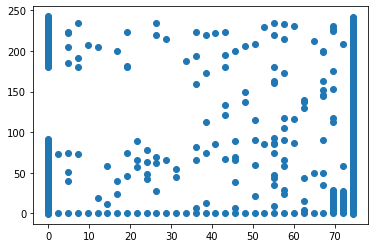

In [493]:
# sanity check to see if missing data (vines) makes sense
plt.scatter(scan2_vine_missing.x, scan2_vine_missing.y)
plt.show()

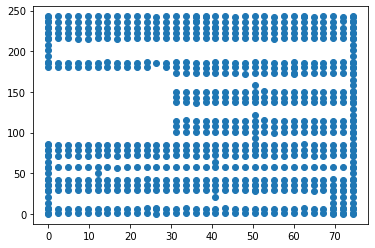

In [494]:
# sanity check to see if missing data (posts) makes sense
plt.scatter(scan2_post_missing.x, scan2_post_missing.y)
plt.show()

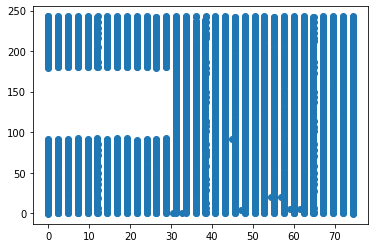

In [495]:
# sanity check to see if all data now still makes sense
plt.scatter(scan2_cleaned.x, scan2_cleaned.y)
plt.show()

##### Map and Combine Data

In [706]:
# check which have been rescanned in scan 2 (round coords to 0 d.p. for rough comparison, vines are 1.8 away so rounding to 0 d.p. isn't too bad)
scan1["x_int"] = scan1.x.round()
scan1["y_int"] = scan1.y.round()
scan2_cleaned["x_int"] = scan2_cleaned.x.round()
scan2_cleaned["y_int"] = scan2_cleaned.y.round()

# get non-missing vine data from the two dataframes
scan1_coords = scan1[["x_int", "y_int"]].reset_index()
scan2_coords = scan2_cleaned[["x_int", "y_int"]].reset_index()

# compute which vine coords have been re-scanned and which are new scans, do outer join first to get overall df
# rescanned_coords = pd.merge(scan1_coords, scan2_coords, how="inner", on=["x_int", "y_int"])
# new_coords = scan2_coords.merge(scan1_coords, how='left', on=["x_int", "y_int"], indicator=True).query("_merge == 'left_only'").drop(columns="_merge")
outer_merge = pd.merge(scan1_coords, scan2_coords, how="outer", on=["x_int", "y_int"])

# rescanned is the outer merge where both index in original dfs exists
rescanned_coords = outer_merge.dropna()

# new coords are where scan 1 is nan, old coords (scanned in scan 1 but not in 2) are where scan 2 is nan
new_coords = outer_merge[outer_merge.index_x.isna()]
old_coords = outer_merge[outer_merge.index_y.isna()]

# sanity check outer merge is correct
assert rescanned_coords.shape[0] + old_coords.shape[0] + new_coords.shape[0] == outer_merge.shape[0], "Merge not correctly interpreted!"

# merged data is just best of rescanned coords + old coords + new coords, also add flag here potential incorrect for data in only 1 scan, and scan number
scan1_vines = scan1.loc[old_coords.index_x]
scan1_vines["PotentialIncorrect"] = 1
scan1_vines["Scan"] = 1
scan2_vines = scan2_cleaned.loc[new_coords.index_y]
scan2_vines["PotentialIncorrect"] = 1
scan1_vines["Scan"] = 2

# for rescanned_coords, pick which one has better quality (Vine Quality), or more recent time, also handles missing values by default as I changed missing values to -1e9
scan1_quality = scan1.loc[rescanned_coords.index_x].VineQuality.values
scan1_quality[pd.isnull(scan1_quality)] = -1e9
scan2_quality = scan2_cleaned.loc[rescanned_coords.index_y].VineQuality.values
scan2_quality[pd.isnull(scan2_quality)] = -1e9

scan1_time = scan1.loc[rescanned_coords.index_x].EpochTime.values
scan1_time[pd.isnull(scan1_time)] = -1e9
scan2_time = scan2_cleaned.loc[rescanned_coords.index_y].EpochTime.values
scan2_time[pd.isnull(scan2_time)] = -1e9

which_scan = np.logical_or(scan2_quality > scan2_quality, np.logical_and(scan2_quality == scan2_quality, scan2_time >= scan1_time))

combined_vines = pd.concat([scan1.loc[rescanned_coords.index_x][~which_scan], scan2_cleaned.loc[rescanned_coords.index_y][which_scan]])
combined_vines["PotentialIncorrect"] = 0
combined_vines["Scan"] = [2 if t else 1 for t in which_scan]

# create final dataframe
scan_both = pd.concat([scan1_vines, scan2_vines, combined_vines]).sort_values(["x", "y"]).reset_index().drop(columns=["x_int", "y_int", "index"])
scan_both

,UniqueId,EpochTime,RowId,BlockId,x,y,Type,Missing,Cane Count,Bud Count,VineQuality,VelocityKph,PotentialIncorrect,Scan
0,NaN,NaN,66055,102,0.000,45.390566,VINE,1,NaN,NaN,NaN,NaN,1,2.0
1,NaN,NaN,66055,102,0.000,47.190566,VINE,1,NaN,NaN,NaN,NaN,1,2.0
2,214200785-0-1691687031,1691687041.45708,66055,102,0.000,49.890566,POST,0,NaN,NaN,100.0,4.173664,0,1.0
3,214200785-0-1691687031,1691687041.45708,66055,102,0.000,49.890566,POST,0,NaN,NaN,100.0,4.173664,0,1.0
4,214200785-5-1691687031,1691687045.33779,66055,102,0.000,54.402867,VINE,0,3.0,34.0,100.0,4.372774,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5944,214200785-472-1691695366,1691696176.95685,66086,102,74.431,230.623637,VINE,0,3.0,21.0,100.0,3.698278,0,2.0
5945,214200785-469-1691695366,1691696171.18072,66086,102,74.431,236.005728,VINE,0,4.0,29.0,100.0,3.483027,0,2.0
5946,214200785-468-1691695366,1691696170.3304,66086,102,74.431,236.902743,POST,0,NaN,NaN,100.0,3.45519,0,2.0
5947,214200785-468-1691695366,1691696170.3304,66086,102,74.431,236.902743,POST,0,NaN,NaN,100.0,3.45519,0,2.0


##### Cropsy Internal Metrics

In [705]:
# For Cropsy internal metrics, report statistics on scan data quality and reproducibility.
# For example: deviation in vine locations between scans, cane and bud count variation across scans, data loss from non-fully scanned rows.


##### Customer Delivery Metrics

In [698]:
# For customer delivery, produce a report that summarises the data on a block and row level.
# Include scan dates, scan percentages, summary stats, and identify vines that are under or overperforming (Using cane and bud data) with respect to neighbouring vines as well as the block as a whole.


4605